In [1]:
import platform
import torch

print("Python version")
!python --version

print("\nOS information")
print(platform.platform())

print("\nIs GPU available?")
print(torch.cuda.is_available())

# print("\nCPU information")
# !cat /proc/cpuinfo

# print("\nMemory information")
# !cat /proc/meminfo

print("\nGPU information")
!nvidia-smi

Python version
Python 3.11.10

OS information
Linux-5.4.0-193-generic-x86_64-with-glibc2.31

Is GPU available?
True

GPU information
Wed Oct  9 18:16:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5000               On  | 00000000:01:00.0 Off |                  Off |
| 30%   33C    P8              16W / 230W |  10938MiB / 24564MiB |      0%      Default |
|                        

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torchvision
import time
import os

In [3]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch
import numpy as np
from tqdm.notebook import tqdm

# Custom Dataset class to load images from a directory and extract labels from filenames
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_labels = self.get_image_labels()

    def get_image_labels(self):
        img_labels = []
        for img_file in os.listdir(self.img_dir):
            # Assuming labels are embedded in the filename, extract them
            label = self.extract_label_from_filename(img_file)
            img_labels.append((img_file, label))
        return img_labels

    def extract_label_from_filename(self, filename):
        # Assuming label is part of the filename, e.g., "cat_001.jpg", where 'cat' is the label
        label = filename.split('_')[-1]  # Extract part before '_'
        return label

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_name, label = self.img_labels[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        return image, label
    
# Custom transformation to resize and pad image while maintaining aspect ratio
class ResizeAndPad:
    def __init__(self, target_size):
        self.target_size = target_size

    def __call__(self, img):
        # Resize the image by maintaining the aspect ratio (128 pixels height)
        w, h = img.size
        new_h = self.target_size
        new_w = int(self.target_size * (w / h))  # Scale width proportionally

        img_resized = img.resize((new_w, new_h), Image.ANTIALIAS)
        
        # If width is less than the target size, add padding to make it 128x128
        if new_w < self.target_size:
            padding = (self.target_size - new_w) // 2
            img_padded = transforms.functional.pad(img_resized, (padding, 0, padding, 0), fill=0)
        else:
            img_padded = img_resized

        return img_padded

# Load the dataset without any normalization
transform = transforms.Compose([
    ResizeAndPad(128),         # Resize height to 128 and pad width if necessary
    transforms.ToTensor()
])

dataset = CustomImageDataset(img_dir='./data/training_image', transform=transform)
loader = DataLoader(dataset, batch_size=64, shuffle=False)

# Initialize variables to calculate mean and std
mean = torch.zeros(3)
std = torch.zeros(3)
n_samples = 0

# Calculate mean and std over all images
for images, _ in tqdm(loader):
    batch_samples = images.size(0)  # batch size (number of images in this batch)
    images = images.view(batch_samples, 3, -1)  # reshape to (batch_size, 3, height*width)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    n_samples += batch_samples

mean /= n_samples
std /= n_samples

print(f"Mean: {mean}")
print(f"Std: {std}")


  0%|          | 0/64 [00:00<?, ?it/s]

/tmp/ipykernel_4134899/2671580056.py:53: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img_resized = img.resize((new_w, new_h), Image.ANTIALIAS)


Mean: tensor([0.4121, 0.3917, 0.3786])
Std: tensor([0.3349, 0.3241, 0.3209])


In [37]:
# Define transformations for train and validation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Define directories for train and validation sets
train_dir = './data/training_image'
val_dir = './data/validation_image'

# Create datasets
train_dataset = CustomImageDataset(img_dir=train_dir, transform=transform_train)
val_dataset = CustomImageDataset(img_dir=val_dir, transform=transform_test)

# Create DataLoaders for batching
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)

print('STEP 1: LOADING DATASET COMPLETE')


STEP 1: LOADING DATASET COMPLETE


In [4]:
reduced_train_dataset = []
for images, labels in train_dataset:
    if labels < 3:
        reduced_train_dataset.append((images, labels))

reduced_test_dataset = []
for images, labels in test_dataset:
    if labels < 3:
        reduced_test_dataset.append((images, labels))

In [5]:
print("The number of training images : ", len(reduced_train_dataset))
print("The number of test images : ", len(reduced_test_dataset))

The number of training images :  15000
The number of test images :  3000


In [6]:
print("The number of classes : ", len(set([labels for _, labels in reduced_train_dataset])))

The number of classes :  3


In [7]:
print('STEP 2: MAKING DATASET ITERABLE')

train_loader = torch.utils.data.DataLoader(dataset=reduced_train_dataset,
                                           batch_size=128,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=reduced_test_dataset,
                                          batch_size=100,
                                          shuffle=False)

class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

STEP 2: MAKING DATASET ITERABLE


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

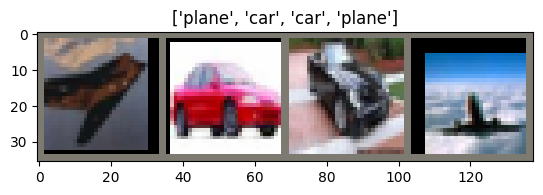

In [10]:
train_loader_sample = torch.utils.data.DataLoader(dataset=reduced_train_dataset,
                                           batch_size=4,
                                           shuffle=True)

# Get a batch of training data
inputs, classes = next(iter(train_loader_sample))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 2. ResNet with PyTorch

### Implementing ResNet

> 1. **Dataset**
>> - The same dataset used for VGGNet
>
> 2. **Network architecture**
>> - 50-layer ResNet with **bottleneck blocks**. <br>
     Note. The initial convolution layer (i.e., conv1) is different from the one in the paper &<br>
     the initial max-pooling layer is removed (because the size of CIFAR-10 images is too small).
>> - ReLU activation.
>> - Strided convolution for down-sampling instead of max-pooling layer. <br>
     Note. Once down-sampled, a $1\times1$ convolution/stride 2 is applied to residual for expanding the channel of the residual.
>> - No dropout for simplicity.
>> - Batch-normalization after every convolution.
>>
>>
>> <table><tr>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1ZYDfpVBFBvQnVezVcJqRxwh09rUVmxwD" alt="no_image" style="width: 500px;"/> </td>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1JNEea1G-5yOKVLmSCkiYAEJ0HXOys0CR" alt="no_image" style="width: 300px;"/> </td>
>> </tr></table>
>>
>> <img src="https://docs.google.com/uc?export=download&id=1vY0ys5KAZmMlOKk8Dcv7eAV8pZ9cawzJ" alt="no_image" style="width: 870px;"/>
>>
>> <font size="0.5"> Figures from <br>
>> [1] https://www.codeproject.com/Articles/1248963/Deep-Learning-using-Python-plus-Keras-Chapter-Re  <br>
>> [2] Rezende et al., *Signal Processing: Image Communication*, 2018. </font>
>
> 3. **Loss function**
>> - Cross-entropy loss between outputs & ground-truths. <br>
>
> 4. **Training**
>> - Default weight initialization for simplicity.
>> - SGD optimizer with `learning rate = 1e-2`, `momentum = 0.9`, and `weight_decay = 5e-4`.
>> - 15 epochs without learning rate scheduling.
>
> 5. **Evaluation metric**
>> - Classification accuracy (i.e., the percentage of correct predictions).
>
>

### 2.1 Implement ResNet50 and train it with the CIFAR 10 dataset

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# STEP 3: CREATE MODEL CLASS (ResNet-18)

cfg = [2, 2, 2, 2]  # ResNet-18 configuration: 4 groups of residual blocks

class ResNet_block(nn.Module):
    def __init__(self, in_c, intra_c, out_c, down_sample=False):
        super(ResNet_block, self).__init__()
        
        stride = 2 if down_sample else 1
        
        self.conv1 = nn.Conv2d(in_c, intra_c, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(intra_c)
        self.conv2 = nn.Conv2d(intra_c, out_c, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_c)
        
        self.down_sample = down_sample
        if self.down_sample or in_c != out_c:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_c)
            )
        else:
            self.shortcut = nn.Identity()
    
    def forward(self, x):
        identity = self.shortcut(x)
        
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        out += identity
        out = F.relu(out)
        
        return out


class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        
        # Initial convolutional block
        self.init_block = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # Bottleneck layers for ResNet-18 (defined by the cfg list)
        self.ResBlock1 = self._make_layers(64, 64, 64, cfg[0], down_sample=False)
        self.ResBlock2 = self._make_layers(64, 128, 128, cfg[1], down_sample=True)
        self.ResBlock3 = self._make_layers(128, 256, 256, cfg[2], down_sample=True)
        self.ResBlock4 = self._make_layers(256, 512, 512, cfg[3], down_sample=True)
        
        # Global average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(512, 3)

    def forward(self, x):
        out = self.init_block(x)
        out = self.ResBlock1(out)
        out = self.ResBlock2(out)
        out = self.ResBlock3(out)
        out = self.ResBlock4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)  # Flatten for the classifier
        out = self.classifier(out)
        return out

    def _make_layers(self, in_c, intra_c, out_c, num_block, down_sample):
        layers = []
        for _ in range(num_block-1):
            layers.append(ResNet_block(in_c, intra_c, out_c))
        layers.append(ResNet_block(out_c, intra_c, out_c, down_sample=down_sample))
        return nn.Sequential(*layers)

# STEP 4: INSTANTIATE MODEL CLASS

model = ResNet()
num_total_params = sum(p.numel() for p in model.parameters())
print("The number of parameters : ", num_total_params)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


The number of parameters :  11523907


ResNet(
  (init_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (ResBlock1): Sequential(
    (0): ResNet_block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Identity()
    )
    (1): ResNet_block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

In [ ]:
### 2.2 Print test accuracy for every epochs. [1 points]

In [33]:
print('STEP 5: INSTANTIATE LOSS CLASS')

criterion = nn.CrossEntropyLoss()

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')

optimizer = optim.Adam(model.parameters(), lr=0.01)

print('STEP 7: TRAIN THE MODEL')
num_epochs = 50

import time

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    correct = torch.sum(preds == labels).item()
    return correct / len(preds) * 100

def train_model(model, criterion, optimizer, num_epochs):
    start = time.time()
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        running_train_acc = 0.0
        running_test_loss = 0.0
        running_test_acc = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            running_train_acc += accuracy(outputs, labels)
        train_loss.append(running_train_loss / len(train_loader))
        train_acc.append(running_train_acc / len(train_loader))
        
        model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()
                running_test_acc += accuracy(outputs, labels)
            test_loss.append(running_test_loss / len(test_loader))
            test_acc.append(running_test_acc / len(test_loader))
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.2f}%, Test Loss: {test_loss[-1]:.4f}, Test Acc: {test_acc[-1]:.2f}%")
        
    end = time.time()
    minute = (end-start)//60
    print(f"Training time: {minute}m {end-start-minute*60:.2f}s")
    return train_loss, train_acc, test_loss, test_acc, model

train_loss, train_acc, test_loss, test_acc, model = train_model(model, criterion, optimizer, num_epochs)


STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS
STEP 7: TRAIN THE MODEL
Epoch 1/50, Train Loss: 0.8726, Train Acc: 66.06%, Test Loss: 0.5477, Test Acc: 78.43%
Epoch 2/50, Train Loss: 0.5897, Train Acc: 76.77%, Test Loss: 1.5377, Test Acc: 77.70%
Epoch 3/50, Train Loss: 0.5277, Train Acc: 79.66%, Test Loss: 0.5120, Test Acc: 81.47%
Epoch 4/50, Train Loss: 0.4457, Train Acc: 83.30%, Test Loss: 0.3967, Test Acc: 85.07%
Epoch 5/50, Train Loss: 0.3817, Train Acc: 85.02%, Test Loss: 0.5448, Test Acc: 80.60%
Epoch 6/50, Train Loss: 0.3892, Train Acc: 84.84%, Test Loss: 0.3647, Test Acc: 86.47%
Epoch 7/50, Train Loss: 0.3271, Train Acc: 87.37%, Test Loss: 0.3244, Test Acc: 86.93%
Epoch 8/50, Train Loss: 0.2831, Train Acc: 89.27%, Test Loss: 0.3674, Test Acc: 86.13%
Epoch 9/50, Train Loss: 0.2584, Train Acc: 90.40%, Test Loss: 0.3079, Test Acc: 88.40%
Epoch 10/50, Train Loss: 0.2239, Train Acc: 91.55%, Test Loss: 0.3423, Test Acc: 87.90%
Epoch 11/50, Train Loss: 0.2160, Train

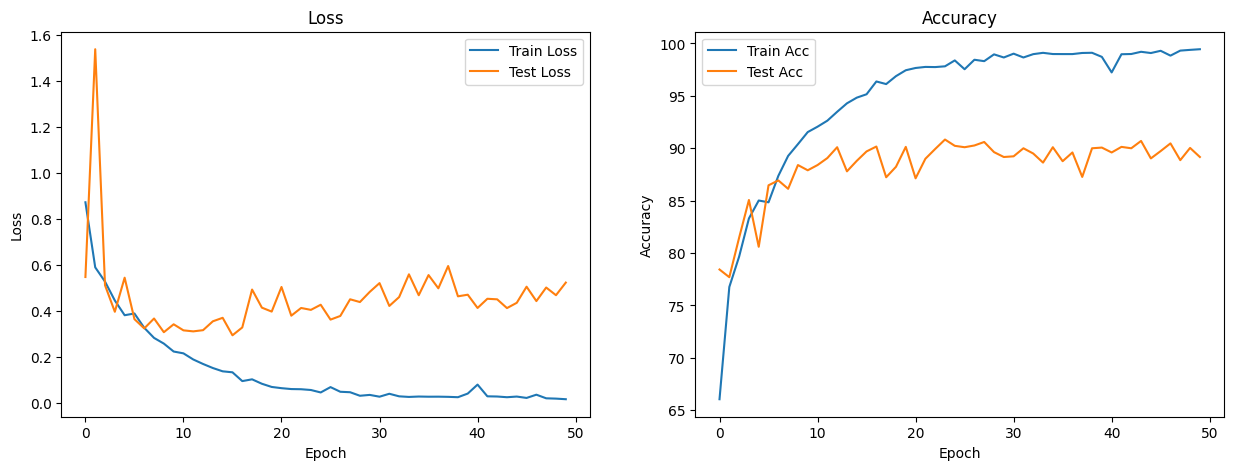

In [34]:
# graph

def display_graph(train_loss, train_acc, test_loss, test_acc):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].plot(train_loss, label='Train Loss')
    ax[0].plot(test_loss, label='Test Loss')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(train_acc, label='Train Acc')
    ax[1].plot(test_acc, label='Test Acc')
    ax[1].set_title('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.show()
    
display_graph(train_loss, train_acc, test_loss, test_acc)

In [36]:
print('TEST THE MODEL and SAVE')

model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 3000 test images: {} %'.format(100 * correct / total))
    
    # Save the model pt
    torch.save(model.state_dict(), 'LAB_1_ResNet18.pt')

TEST THE MODEL and SAVE
Test Accuracy of the model on the 3000 test images: 89.16666666666667 %


Load PT Model and VISUALIZE THE RESULT


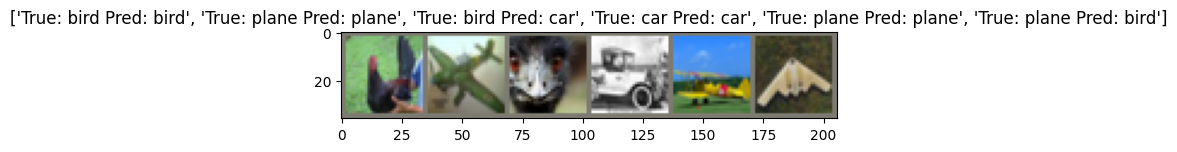

In [18]:
print('Load PT Model and VISUALIZE THE RESULT')

loaded_model = ResNet()
loaded_model.to(device)
loaded_model.load_state_dict(torch.load('LAB_1_ResNet50.pt', map_location=device, weights_only=False))

with torch.no_grad():
    model.eval()
    # Visualize the result of only 4 images
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    
    # Select only the first 4 images and labels
    images = images[5:11]
    labels = labels[5:11]
    
    outputs = loaded_model(images)
    _, predicted = torch.max(outputs.data, 1)
    
    # Make a grid from the batch
    out = torchvision.utils.make_grid(images.cpu())
    
    # Show images with Ground Truth and Predictions
    imshow(out, title=[f'True: {class_names[x]} Pred: {class_names[y]}' for x, y in zip(labels, predicted)])